In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def proportion_positive(L):
    n_total = len(L)
    n_pos = np.sum(L == 1)

    return n_pos / n_total

In [3]:
Embeddings_ABCD= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/epilepsy_PBS/Embeddings.csv")

In [4]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [5]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [6]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})
Embeddings_ABCD  = Embeddings_ABCD.rename(columns={Embeddings_ABCD.columns[0]: "Index"})

In [7]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
Embeddings_irm_negatives = Embeddings_epilepsy.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
Embeddings_irm_positives = Embeddings_epilepsy.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

In [8]:
X1 = Embeddings_ABCD.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_irm_negatives.iloc[:,1:76]
X5= Embeddings_irm_positives.iloc[:,1:76]

In [9]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)
X5=scaler.transform(X5)

UMAP

In [10]:
reducer = umap.UMAP(n_components=2, random_state=42)
X1_umap2 = reducer.fit_transform(X1)
X2_umap2 = reducer.transform(X2)
X3_umap2= reducer.transform(X3)
X4_umap2=reducer.transform(X4)
X5_umap2=reducer.transform(X5)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


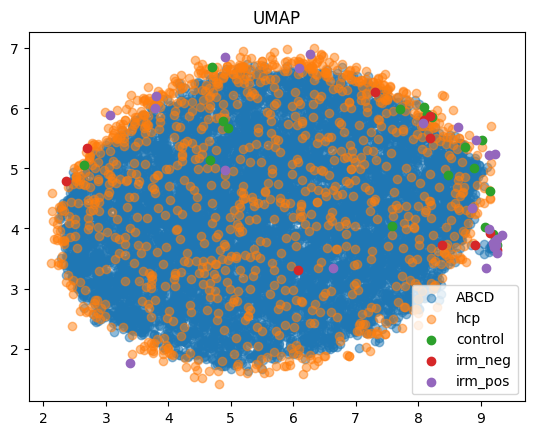

In [13]:
plt.scatter(X1_umap2[:,0], X1_umap2[:,1], alpha=0.5, label="ABCD")
plt.scatter(X2_umap2[:,0], X2_umap2[:,1], alpha=0.5, label="hcp")
plt.scatter(X3_umap2[:,0], X3_umap2[:,1], label="control")
plt.scatter(X4_umap2[:,0], X4_umap2[:,1], label="irm_neg")
plt.scatter(X5_umap2[:,0], X5_umap2[:,1] , label="irm_pos")

plt.legend()
plt.title('UMAP')
plt.show()

In [12]:
datasets = [X1, X2, X3, X4, X5]
X_all = np.vstack(datasets)

y_true = np.concatenate([[i]*len(Xi) for i, Xi in enumerate(datasets)]) #true label

Clustering

In [14]:
dbscan = DBSCAN(eps=10**(-10), min_samples=10)
y_pred = dbscan.fit_predict(X_all)


In [15]:
X_umap= np.concatenate((X1_umap2, X2_umap2, X3_umap2, X4_umap2, X5_umap2), axis=0)

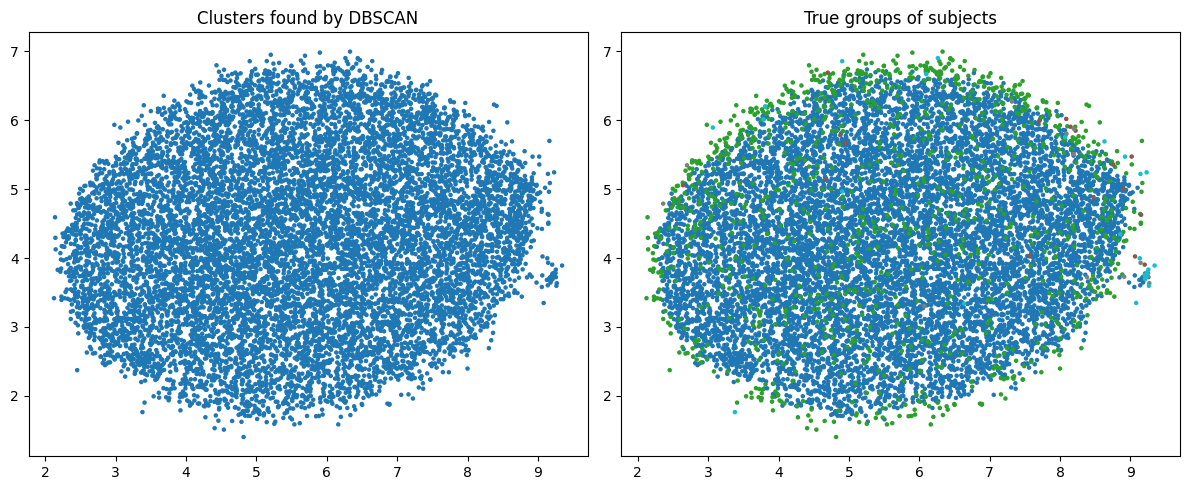

In [16]:
plt.figure(figsize=(12,5))

# Clusters found by clustering
plt.subplot(1,2,1)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_pred, cmap='tab10', s=5)
plt.title("Clusters found by DBSCAN")

# true
plt.subplot(1,2,2)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_true, cmap='tab10', s=5)
plt.title("True groups of subjects")

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("ARI :", adjusted_rand_score(y_true, y_pred))
print("NMI :", normalized_mutual_info_score(y_true, y_pred))

ARI : 0.0
NMI : 0.0


In [18]:
dbscan = DBSCAN(eps=0.01, min_samples=10)
y_pred = dbscan.fit_predict(X_umap)

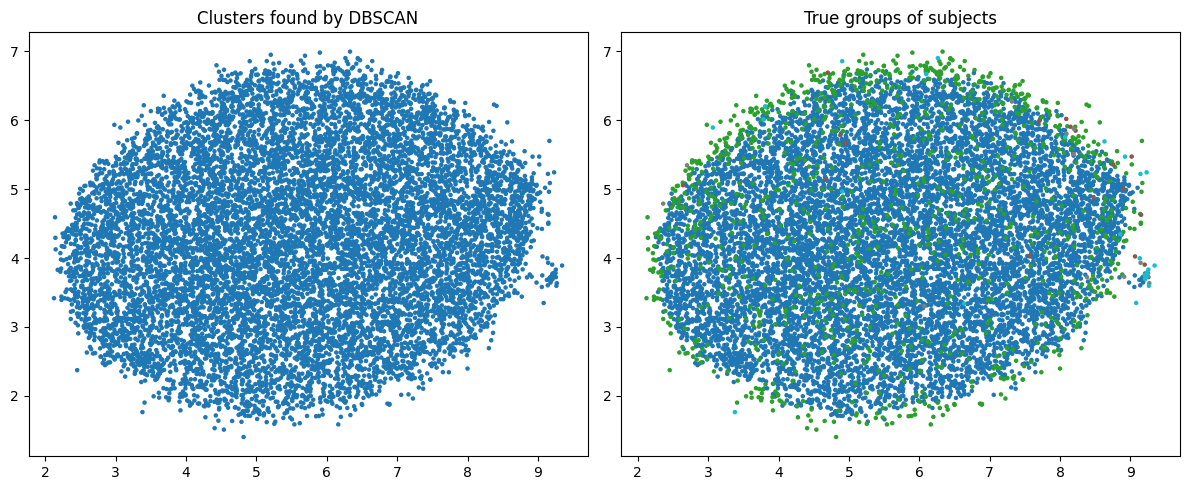

In [19]:
plt.figure(figsize=(12,5))

# Clusters found by clustering
plt.subplot(1,2,1)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_pred, cmap='tab10', s=5)
plt.title("Clusters found by DBSCAN")

# true
plt.subplot(1,2,2)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_true, cmap='tab10', s=5)
plt.title("True groups of subjects")

plt.tight_layout()
plt.show()

One class SVM

In [20]:
from sklearn.svm import OneClassSVM

In [21]:
clf = OneClassSVM(kernel='rbf')
clf.fit(X1)

y1 = clf.predict(X1)
y2 = clf.predict(X2)
y3 = clf.predict(X3)
y4 = clf.predict(X4)
y5 = clf.predict(X5)

In [23]:
clf = OneClassSVM(kernel='rbf')
clf.fit(X1_umap2)

y1 = clf.predict(X1_umap2)
y2 = clf.predict(X2_umap2)
y3 = clf.predict(X3_umap2)
y4 = clf.predict(X4_umap2)
y5 = clf.predict(X5_umap2)

In [24]:
print(f'ABCD :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')
print(f'irm_pos :{proportion_positive(y5)}')

ABCD :0.5000493242576699
HCP :0.2666068222621185
Control :0.10526315789473684
irm_neg :0.07692307692307693
irm_pos :0.08


In [25]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []


for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1)

    y1 = clf.predict(X1)
    y2 = clf.predict(X2)
    y3 = clf.predict(X3)
    y4 = clf.predict(X4)
    y5 = clf.predict(X5)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))

total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) 


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


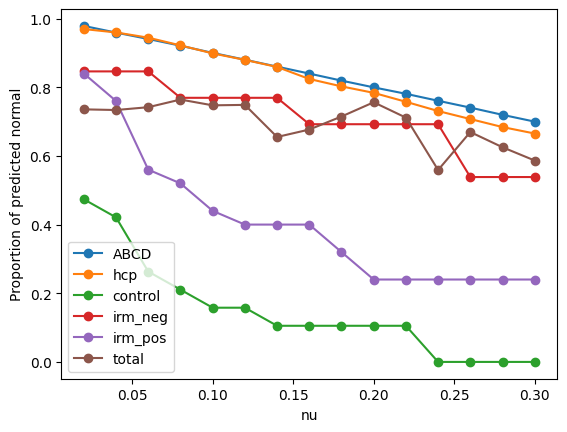

In [26]:
plt.plot(nu, prop_positive_ABCD, marker='o', linestyle='-', label="ABCD")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")

plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [27]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)
    y5 = clf.predict(X5_umap2)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))


total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) 

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


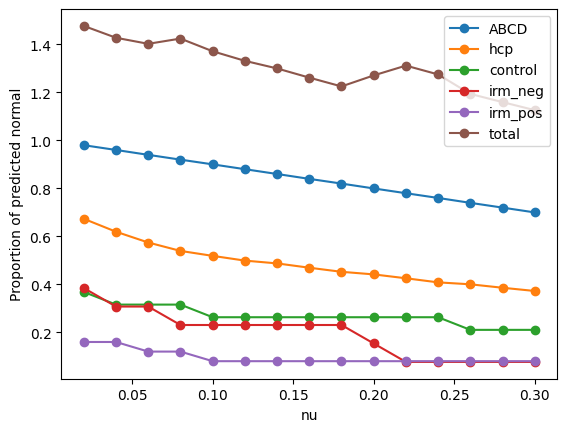

In [28]:
plt.plot(nu, prop_positive_ABCD, marker='o', linestyle='-', label="ABCD")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Isolation Forest

In [29]:
from sklearn.ensemble import IsolationForest

In [ ]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1)

    y1 = clf.predict(X1)
    y2 = clf.predict(X2)
    y3 = clf.predict(X3)
    y4 = clf.predict(X4)
    y5 = clf.predict(X5)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))

total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos)

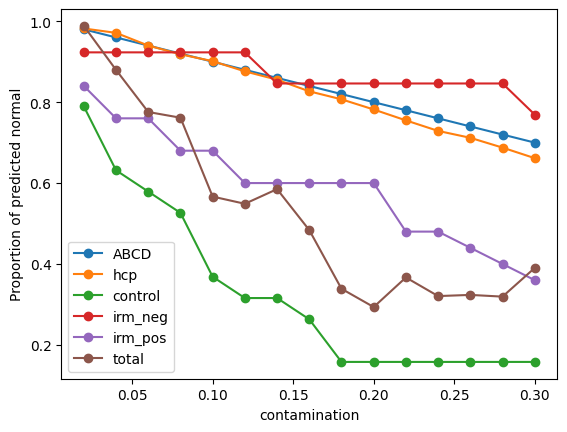

In [32]:
plt.plot(contamination, prop_positive_ABCD, marker='o', linestyle='-', label="ABCD")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

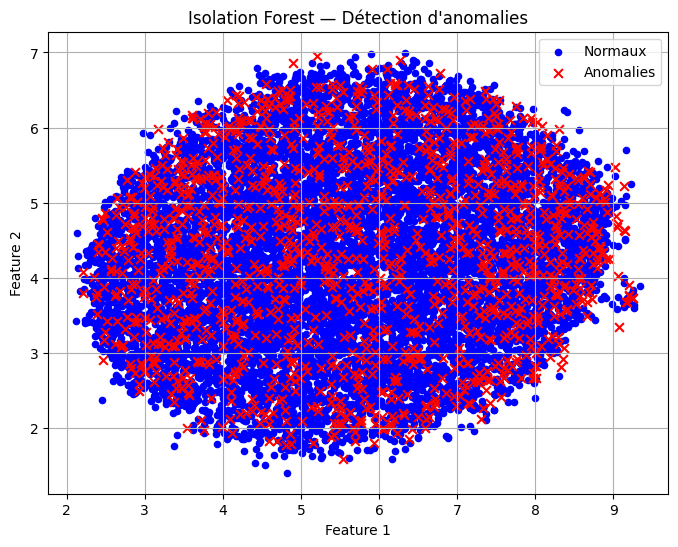

In [33]:
X_total_umap = np.concatenate((X1_umap2, X2_umap2, X3_umap2, X4_umap2, X5_umap2), axis=0)
X_total = np.concatenate((X1, X2, X3, X4, X5), axis=0)

clf = IsolationForest(contamination=0.12, random_state=42)
clf.fit(X1)

y_pred = clf.predict(X_total)
normal = X_total_umap[y_pred == 1]
anomaly = X_total_umap[y_pred == -1]

plt.figure(figsize=(8, 6))
plt.scatter(normal[:, 0], normal[:, 1], c='blue', s=20, label="Normaux")
plt.scatter(anomaly[:, 0], anomaly[:, 1], c='red', s=40, label="Anomalies", marker='x')

plt.title("Isolation Forest — Détection d'anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap2)


    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)
    y5 = clf.predict(X5_umap2)


    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))


total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos)

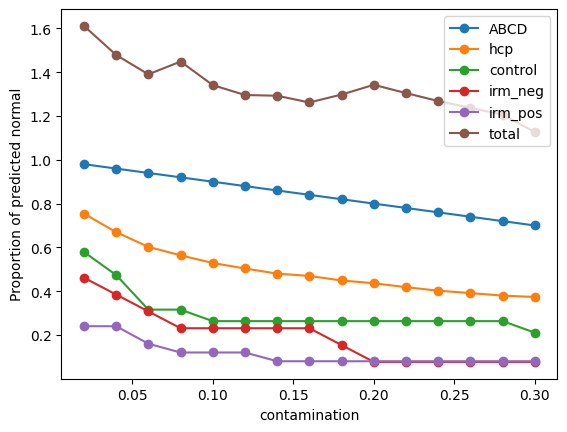

In [37]:
plt.plot(contamination, prop_positive_ABCD, marker='o', linestyle='-', label="ABCD")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

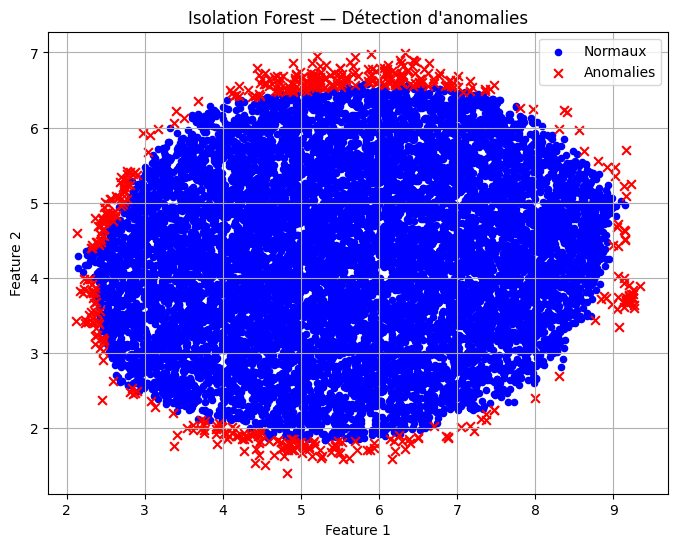

In [39]:
X_total= np.concatenate((X1_umap2, X2_umap2, X3_umap2, X4_umap2, X5_umap2), axis=0)


clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(X1_umap2)

y_pred = clf.predict(X_total)
normal = X_total[y_pred == 1]
anomaly = X_total[y_pred == -1]

plt.figure(figsize=(8, 6))
plt.scatter(normal[:, 0], normal[:, 1], c='blue', s=20, label="Normaux")
plt.scatter(anomaly[:, 0], anomaly[:, 1], c='red', s=40, label="Anomalies", marker='x')

plt.title("Isolation Forest — Détection d'anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

LOF (Local Otlier Factor)

In [40]:
from sklearn.neighbors import LocalOutlierFactor

In [41]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1)
    y1 = lof.predict(X1)
    y2 = lof.predict(X2)
    y3 = lof.predict(X3)
    y4 = lof.predict(X4)
    y5 = lof.predict(X5)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))

total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) 


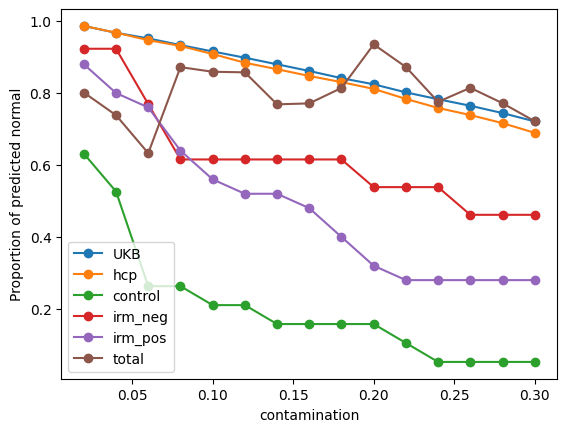

In [42]:
plt.plot(contamination, prop_positive_ABCD, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [43]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap2)
    y1 = lof.predict(X1_umap2)
    y2 = lof.predict(X2_umap2)
    y3 = lof.predict(X3_umap2)
    y4 = lof.predict(X4_umap2)
    y5 = lof.predict(X5_umap2)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))

total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) 


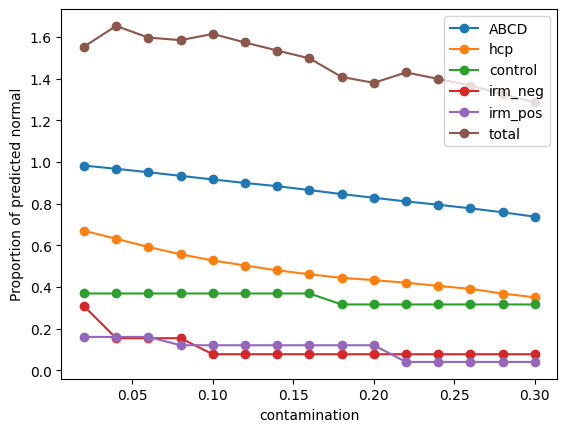

In [44]:
plt.plot(contamination, prop_positive_ABCD, marker='o', linestyle='-', label="ABCD")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

ABOD (Angle-Based Outliers Detection)

In [46]:
from pyod.models.abod import ABOD

In [47]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1)

    y1 =1-  clf.predict(X1)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2)
    y3 = 1- clf.predict(X3)
    y4 = 1-  clf.predict(X4)
    y5 = 1- clf.predict(X5)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))

total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


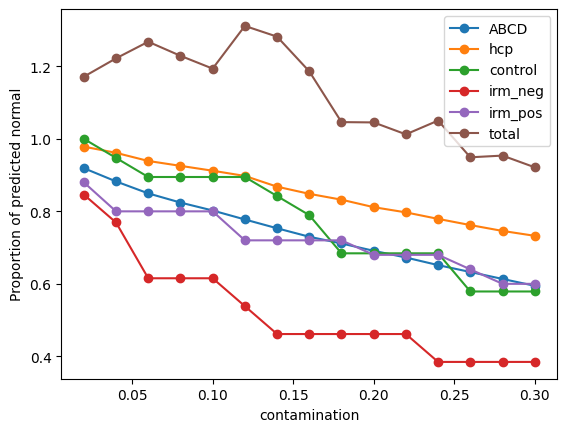

In [48]:
plt.plot(contamination, prop_positive_ABCD, marker='o', linestyle='-', label="ABCD")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [49]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_ABCD= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []

for a in contamination:

    clf = ABOD(contamination=a)
    clf.fit(X1_umap2)


    y1 =1-  clf.predict(X1_umap2)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap2)
    y3 = 1- clf.predict(X3_umap2)
    y4 = 1-  clf.predict(X4_umap2)
    y5 = 1- clf.predict(X5_umap2)

    prop_positive_ABCD.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))

total = np.array(prop_positive_ABCD)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) 


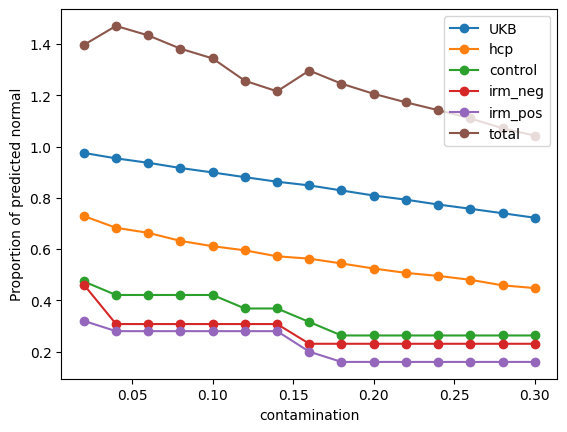

In [50]:
plt.plot(contamination, prop_positive_ABCD, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Feature bagging

In [106]:
from sklearn.svm import OneClassSVM

In [107]:
nu = np.arange(0.01,0.41,0.01)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

n_models = 51 
M=75 #nbres de dimensions      
subset_size = M // 2  
for u in nu:
    predictions_all1 = np.zeros((X1.shape[0], n_models))
    predictions_all2 = np.zeros((X2.shape[0], n_models))
    predictions_all3 = np.zeros((X3.shape[0], n_models))
    predictions_all4 = np.zeros((X4.shape[0], n_models))
    predictions_all5 = np.zeros((X5.shape[0], n_models))
    predictions_all6 = np.zeros((X6.shape[0], n_models))

    for i in range(n_models):
        # Sélection aléatoire d'un sous-ensemble de features
        features_idx = np.random.choice(M, subset_size, replace=False)
        X_subset1 = X1[:, features_idx]
        X_subset2 = X2[:, features_idx]
        X_subset3 = X3[:, features_idx]
        X_subset4 = X4[:, features_idx]
        X_subset5 = X5[:, features_idx]
        X_subset6 = X6[:, features_idx]

        clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
        clf.fit(X_subset1)
        y_pred1 = clf.predict(X_subset1)
        y_pred2 = clf.predict(X_subset2)
        y_pred3 = clf.predict(X_subset3)
        y_pred4 = clf.predict(X_subset4)
        y_pred5 = clf.predict(X_subset5)
        y_pred6 = clf.predict(X_subset6)

        predictions_all1[:, i] = y_pred1
        predictions_all2[:, i] = y_pred2
        predictions_all3[:, i] = y_pred3
        predictions_all4[:, i] = y_pred4
        predictions_all5[:, i] = y_pred5
        predictions_all6[:, i] = y_pred6

    y1 = (predictions_all1.mean(axis=1) > 0).astype(int)
    y2 = (predictions_all2.mean(axis=1) > 0).astype(int)
    y3 = (predictions_all3.mean(axis=1) > 0).astype(int)
    y4 = (predictions_all4.mean(axis=1) > 0).astype(int)
    y5 = (predictions_all5.mean(axis=1) > 0).astype(int)
    y6 = (predictions_all6.mean(axis=1) > 0).astype(int)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)

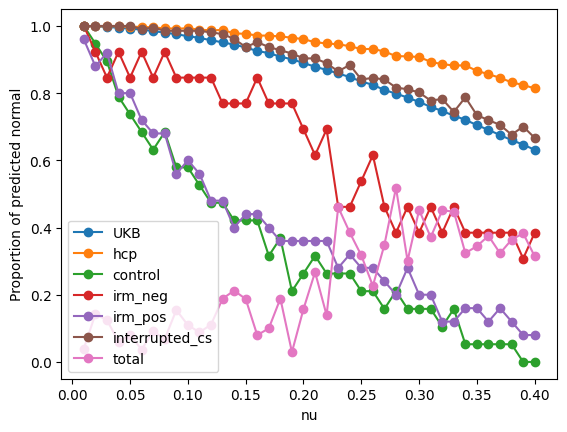

In [108]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

One-class SVM

In [ ]:
from sklearn.svm import OneClassSVM

umap 3D

In [ ]:
reducer = umap.UMAP(n_components=3, random_state=42)
X1_umap3 = reducer.fit_transform(X1)
X2_umap3 = reducer.transform(X2)
X3_umap3= reducer.transform(X3)
X4_umap3=reducer.transform(X4)
X5_umap3=reducer.transform(X5)
X6_umap3=reducer.transform(X6)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
nu= np.arange(0.01,0.51,0.01)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap3)

    y1 = clf.predict(X1_umap3)
    y2 = clf.predict(X2_umap3)
    y3 = clf.predict(X3_umap3)
    y4 = clf.predict(X4_umap3)
    y5 = clf.predict(X5_umap3)
    y6 = clf.predict(X6_umap3)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5


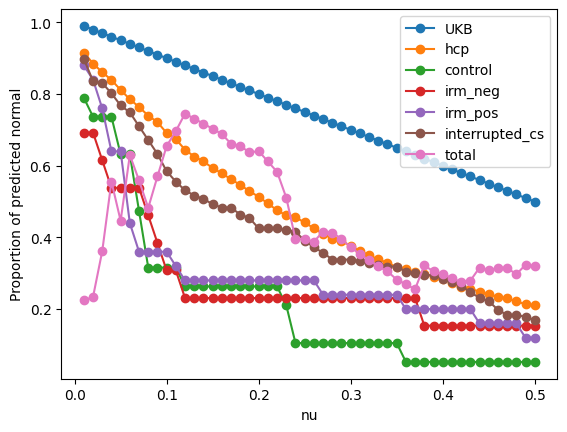

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Umap 4D

In [ ]:
reducer = umap.UMAP(n_components=4, random_state=42)
X1_umap4 = reducer.fit_transform(X1)
X2_umap4 = reducer.transform(X2)
X3_umap4= reducer.transform(X3)
X4_umap4=reducer.transform(X4)
X5_umap4=reducer.transform(X5)
X6_umap4=reducer.transform(X6)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
nu= np.arange(0.01,0.51,0.01)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap4)

    y1 = clf.predict(X1_umap4)
    y2 = clf.predict(X2_umap4)
    y3 = clf.predict(X3_umap4)
    y4 = clf.predict(X4_umap4)
    y5 = clf.predict(X5_umap4)
    y6 = clf.predict(X6_umap4)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5


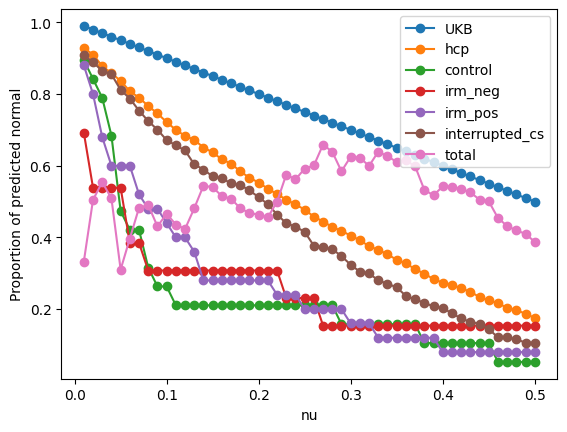

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Umap 5D

In [ ]:
reducer = umap.UMAP(n_components=5, random_state=42)
X1_umap5 = reducer.fit_transform(X1)
X2_umap5 = reducer.transform(X2)
X3_umap5= reducer.transform(X3)
X4_umap5=reducer.transform(X4)
X5_umap5=reducer.transform(X5)
X6_umap5=reducer.transform(X6)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap5)

    y1 = clf.predict(X1_umap5)
    y2 = clf.predict(X2_umap5)
    y3 = clf.predict(X3_umap5)
    y4 = clf.predict(X4_umap5)
    y5 = clf.predict(X5_umap5)
    y6 = clf.predict(X6_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


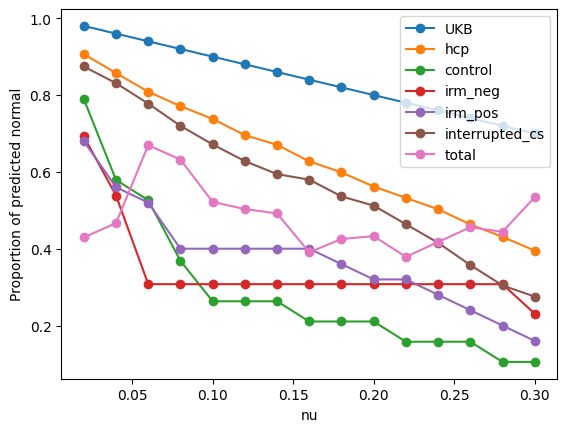

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 10D

In [ ]:
reducer = umap.UMAP(n_components=10, random_state=42)
X1_umap10 = reducer.fit_transform(X1)
X2_umap10 = reducer.transform(X2)
X3_umap10 = reducer.transform(X3)
X4_umap10 =reducer.transform(X4)
X5_umap10 =reducer.transform(X5)
X6_umap10 =reducer.transform(X6)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap10)

    y1 = clf.predict(X1_umap10)
    y2 = clf.predict(X2_umap10)
    y3 = clf.predict(X3_umap10)
    y4 = clf.predict(X4_umap10)
    y5 = clf.predict(X5_umap10)
    y6 = clf.predict(X6_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


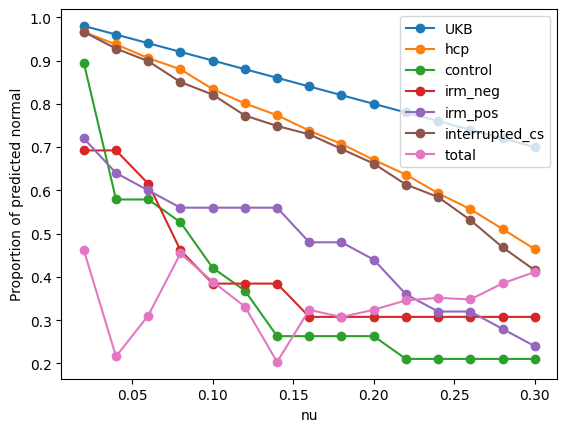

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Umap 20D

In [ ]:
reducer = umap.UMAP(n_components=20, random_state=42)
X1_umap20 = reducer.fit_transform(X1)
X2_umap20 = reducer.transform(X2)
X3_umap20 = reducer.transform(X3)
X4_umap20 =reducer.transform(X4)
X5_umap20 =reducer.transform(X5)
X6_umap20 =reducer.transform(X6)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap20)

    y1 = clf.predict(X1_umap20)
    y2 = clf.predict(X2_umap20)
    y3 = clf.predict(X3_umap20)
    y4 = clf.predict(X4_umap20)
    y5 = clf.predict(X5_umap20)
    y6 = clf.predict(X6_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


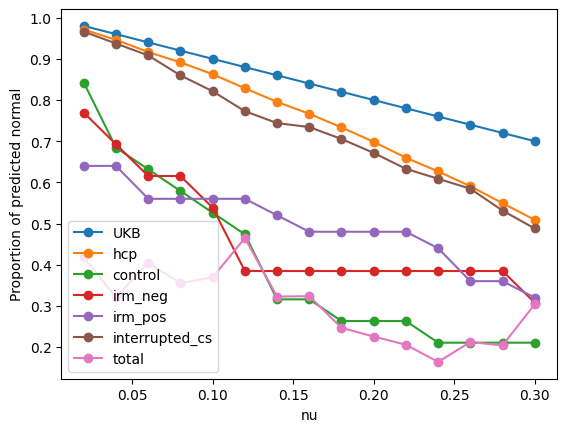

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

umap 30D

In [ ]:
reducer = umap.UMAP(n_components=30, random_state=42)
X1_umap30 = reducer.fit_transform(X1)
X2_umap30 = reducer.transform(X2)
X3_umap30 = reducer.transform(X3)
X4_umap30 =reducer.transform(X4)
X5_umap30 =reducer.transform(X5)
X6_umap30 =reducer.transform(X6)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap30)

    y1 = clf.predict(X1_umap30)
    y2 = clf.predict(X2_umap30)
    y3 = clf.predict(X3_umap30)
    y4 = clf.predict(X4_umap30)
    y5 = clf.predict(X5_umap30)
    y6 = clf.predict(X6_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


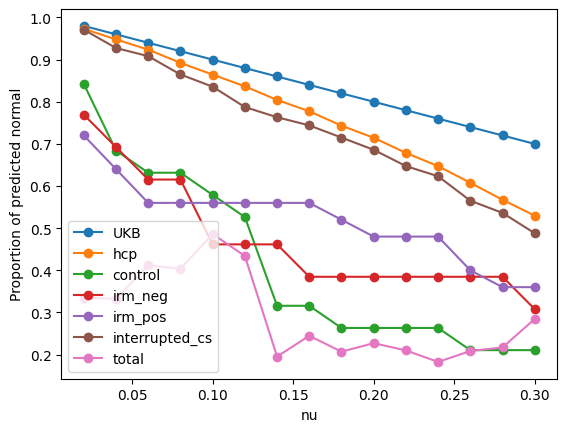

In [ ]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

LOF

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap5)
    y1 = lof.predict(X1_umap5)
    y2 = lof.predict(X2_umap5)
    y3 = lof.predict(X3_umap5)
    y4 = lof.predict(X4_umap5)
    y5 = lof.predict(X5_umap5)
    y6 = lof.predict(X6_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


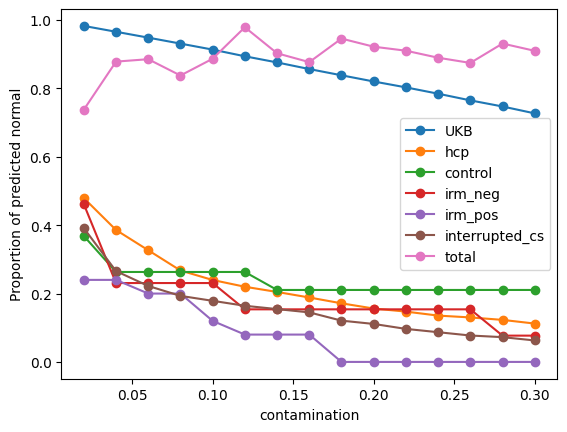

In [ ]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [ ]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap10)
    y1 = lof.predict(X1_umap10)
    y2 = lof.predict(X2_umap10)
    y3 = lof.predict(X3_umap10)
    y4 = lof.predict(X4_umap10)
    y5 = lof.predict(X5_umap10)
    y6 = lof.predict(X6_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


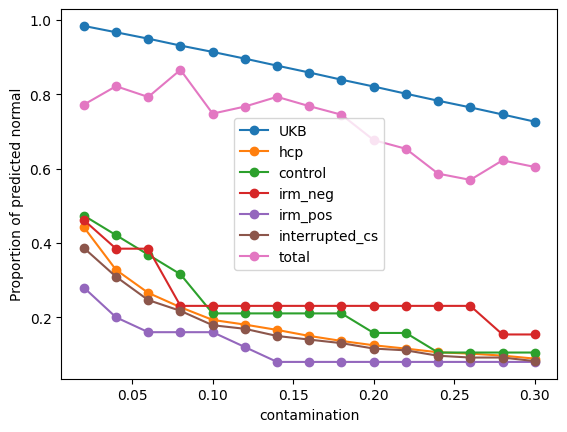

In [ ]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [ ]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap20)
    y1 = lof.predict(X1_umap20)
    y2 = lof.predict(X2_umap20)
    y3 = lof.predict(X3_umap20)
    y4 = lof.predict(X4_umap20)
    y5 = lof.predict(X5_umap20)
    y6 = lof.predict(X6_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


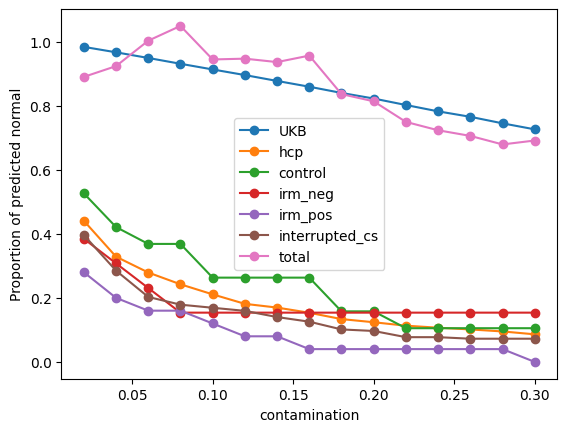

In [ ]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [ ]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap30)
    y1 = lof.predict(X1_umap30)
    y2 = lof.predict(X2_umap30)
    y3 = lof.predict(X3_umap30)
    y4 = lof.predict(X4_umap30)
    y5 = lof.predict(X5_umap30)
    y6 = lof.predict(X6_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)


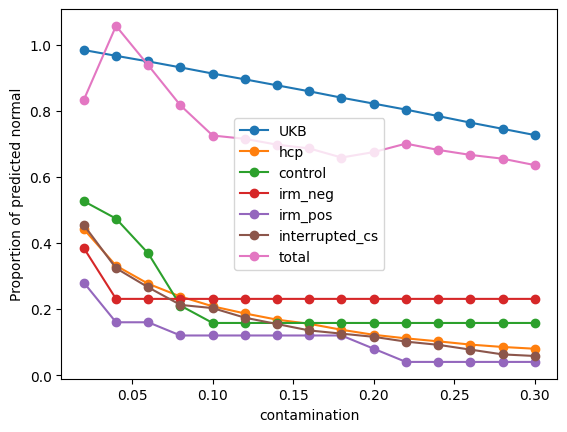

In [ ]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()